<a href="https://colab.research.google.com/github/tesa0/ML_python/blob/main/ALL_DFpreparation%2BLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs and files

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sb     
import matplotlib.pyplot as plt     
import datetime
import sklearn.model_selection
import sklearn.metrics
import re 

from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score,precision_recall_curve # plot_confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint,Callback,BackupAndRestore
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
from tensorflow.keras import utils   
from tensorflow.keras.optimizers import Adam, Adadelta 

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/MyDrive/MA/t1_20220101_20220726_rg_201589066.csv'            # счетчик 1.1, цель 201589066, 22-01-01 - 22-07-26 visits
df_11_201589066 = pd.read_csv(file_path1, header=0)
file_path12 = '/content/drive/MyDrive/MA/t1_20220601_20220621_rg_201589066.csv'            # счетчик 1.2, цель 201589066, 22-06-01 - 22-06-21 visits
df_12_201589066 = pd.read_csv(file_path12, header=0)
file_path2 = '/content/drive/MyDrive/MA/t2_20190101_20191231_rg_201711160.csv'            # счетчик 2, цель 201711160, 2019 visits
df_2_201711160 = pd.read_csv(file_path2, header=0)
file_path3 = '/content/drive/MyDrive/MA/t3_20220101_20230106 rg_184390113,199898941.csv'  # счетчик 3, цели 184390113/199898941, 22-01-01 - 23-01-06 visits
df_3_184390113_199898941 = pd.read_csv(file_path3, header=0)
file_path4 = '/content/drive/MyDrive/MA/t4_20220601_20220621_rg_106176610.csv'            # счетчик 4, цель 106176610, 22-06-01 - 22-06-21 visits
df_4_106176610 = pd.read_csv(file_path4, header=0)

In [74]:
df11 = df_11_201589066.copy()
df12 = df_12_201589066.copy()
df2 = df_2_201711160.copy()
df3 = df_3_184390113_199898941.copy()
df4 = df_4_106176610.copy()

## Prepare data for train - Assign 1 if goal reached and 0 if not

In [75]:
goals = ['201589066','201589066','201711160','106176610']
dfs = [df11, df12, df2, df4]
for goal, df in zip(goals, dfs): 
  
  success = df['ym:s:goalsID'].str.contains(goal)
  # Assign 1 if goal reached and 0 if not
  df['ym:s:goalsID'].loc[success] = 1
  df['ym:s:goalsID'].loc[~success] = 0

  print(f'Goal {goal} reached in ', success.sum(), 'of', df.shape[0],'visits')

goal31 = '184390113'
goal32 = '199898941'
success = (df3['ym:s:goalsID'].str.contains(goal31))|(df3['ym:s:goalsID'].str.contains(goal31))
# Assign 1 if goal reached and 0 if not
df3['ym:s:goalsID'].loc[success] = 1
df3['ym:s:goalsID'].loc[~success] = 0
print('Goal reached in', success.sum(), 'of', df3.shape[0],'visits')

Goal 201589066 reached in  1307 of 361919 visits
Goal 201589066 reached in  119 of 33960 visits
Goal 201711160 reached in  0 of 831061 visits
Goal 106176610 reached in  224 of 306922 visits
Goal reached in 868 of 734358 visits


We cannot train df2 dataset

## Clean data from nan

In [76]:
def cols_to_drop(df):
  cols_to_drop = ['Unnamed: 0.1','Unnamed: 0','ym:s:from','ym:s:lastSocialNetworkProfile',
                'ym:s:lastSocialNetwork','ym:s:openstatAd','ym:s:openstatCampaign','ym:s:openstatService',
                'ym:s:openstatSource','ym:s:browserCountry','ym:s:firstGCLID','ym:s:lastDirectClickOrder',
                'ym:s:lastDirectPlatform','ym:s:lastGCLID','ym:s:lastReferalSource',
                'ym:s:lastSignificantGCLID','ym:s:networkType', 'ym:s:referer','ym:s:regionCity',
                'ym:s:UTMCampaign','ym:s:UTMContent','ym:s:UTMSource','ym:s:UTMTerm','ym:s:browserLanguage',
                'ym:s:cookieEnabled','ym:s:goalsPrice','ym:s:goalsSerialNumber',
                'ym:s:ipAddress','ym:s:impressionsProductCoupon','ym:s:offlineCallHoldDuration',
                'ym:s:offlineCallMissed','ym:s:offlineCallURL','ym:s:watchIDs']
  df.drop(cols_to_drop, axis=1,inplace=True)
  return df

In [77]:
df11 = cols_to_drop(df11)

In [78]:
df12 = cols_to_drop(df12)

In [79]:
df3 = cols_to_drop(df3)

In [80]:
df4 = cols_to_drop(df4)

In [81]:
def clean_df(df1):

  df1['ym:s:date'] = [pd.to_datetime(x) for x in df1['ym:s:date']]
  df1['ym:s:lastDirectBannerGroup'] = [0 if el==0 else 1 for el in df1['ym:s:lastDirectBannerGroup']]

  df1['ym:s:offlineCallTag'] = ['1' if '1' in el else el for el in df1['ym:s:offlineCallTag']]
  df1['ym:s:offlineCallTag'] = ['1' if '2' in el else el for el in df1['ym:s:offlineCallTag']]
  df1['ym:s:offlineCallTag'] = ['1' if '3' in el else el for el in df1['ym:s:offlineCallTag']]
  df1['ym:s:offlineCallTag'] = ['1' if '4' in el else el for el in df1['ym:s:offlineCallTag']]
  df1['ym:s:offlineCallTag'] = [1 if '1' in el else 0 for el in df1['ym:s:offlineCallTag']]

  df1['ym:s:endURL'] = [x[7:] for x in df1['ym:s:endURL']]
  df1['ym:s:startURL'] = [x[9:] for x in df1['ym:s:startURL']]

  df1['ym:s:offlineCallTalkDuration'] = [x[1:-1] for x in df1['ym:s:offlineCallTalkDuration']]
  df1['ym:s:offlineCallTalkDuration'] = [x.replace("''","") for x in df1['ym:s:offlineCallTalkDuration']]
  df1['ym:s:offlineCallTalkDuration'] = ['0' if x == '' else max(x.split(',')) for x in df1['ym:s:offlineCallTalkDuration']]
  df1['ym:s:offlineCallTalkDuration'] = [int(x) for x in df1['ym:s:offlineCallTalkDuration']]
  df1['ym:s:offlineCallTalkDuration'] = df1['ym:s:offlineCallTalkDuration']/max(df1['ym:s:offlineCallTalkDuration'])

  df1['ym:s:diagonal'] = ((df1['ym:s:screenHeight']**2+df1['ym:s:screenWidth']**2)**0.5)
  df1['ym:s:diagonal'] = round(df1['ym:s:diagonal'] / max(df1['ym:s:diagonal']),2)

  df1 = df1.drop(['ym:s:screenHeight', 'ym:s:screenWidth'], axis=1)

  df1['ym:s:lastDirectClickBanner'] = [0 if el==0 else 1 for el in df1['ym:s:lastDirectClickBanner']]

  df1['ym:s:lastDirectClickBannerName'] = [re.sub(r'[^0-9]', '', x) for x in df1['ym:s:lastDirectClickBannerName'].astype(str)]
  df1['ym:s:lastDirectClickBannerName'] = [int(x) for x in df1['ym:s:lastDirectClickBannerName']]
  df1['ym:s:lastDirectClickBannerName'] = round((df1['ym:s:lastDirectClickBannerName'])/max(df1['ym:s:lastDirectClickBannerName']),2)

  df1['ym:s:visitDuration'] = round((df1['ym:s:visitDuration'])/max(df1['ym:s:visitDuration']),2)

  df1['ym:s:lastDirectPhraseOrCond'] = [x[23:] for x in df1['ym:s:lastDirectPhraseOrCond']]


  df1['ym:s:goalsDateTime'] = [x.replace("[","") for x in df1['ym:s:goalsDateTime']]
  df1['ym:s:goalsDateTime'] = [x.replace("]","") for x in df1['ym:s:goalsDateTime']]
  df1['ym:s:goalsDateTime'] = [x[2:12] for x in df1['ym:s:goalsDateTime']]
  df1 = df1.drop(df1[df1['ym:s:goalsDateTime']==''].index) # ---------------------------------------------
  df1['ym:s:goalsDateTime'] = [datetime.strptime(x, '%Y-%m-%d') for x in df1['ym:s:goalsDateTime']]

  df1['ym:s:deltaTime'] = df1['ym:s:goalsDateTime'] - df1['ym:s:date']
  df1['ym:s:deltaTime'] = [x.components.days for x in df1['ym:s:deltaTime']]
  df1['ym:s:deltaTime'] = df1['ym:s:deltaTime']/max(df1['ym:s:deltaTime'] )

  df1.drop(['ym:s:date', 'ym:s:goalsDateTime'], axis=1, inplace=True)
  

  return df1

In [82]:
df11 = clean_df(df11)

In [83]:
df12 = clean_df(df12)

In [84]:
df3 = clean_df(df3)

In [85]:
df4 = clean_df(df4)

In [86]:
df11['ym:s:lastClickBannerGroupName'] = [el.lower() for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['2022' if '2022' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['фили' if 'фили' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['Headliner' if 'headliner' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['застройщик' if 'застройщик' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['Не отказ' if 'не отказ' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['конкурент' if 'конкурент' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['запрос' if 'запрос' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['2021' if '2021' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['жк' if 'жк' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['центр сити' if 'центр сити' in el else el for el in df11['ym:s:lastClickBannerGroupName']]
df11['ym:s:lastClickBannerGroupName'] = ['москва' if 'москв' in el else el for el in df11['ym:s:lastClickBannerGroupName']]

In [87]:
df12['ym:s:lastClickBannerGroupName'] = [el.lower() for el in df12['ym:s:lastClickBannerGroupName'].astype(str)]
df12['ym:s:lastClickBannerGroupName'] = ['2022' if '2022' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['айти' if 'it' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['бизнес' if 'бизнес' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['неотказ' if 'не отказ' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['хэд' if 'headliner' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['запад' if 'запад' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['москва' if 'москв' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['москва' if 'city' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['москва' if 'сити' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['москва' if 'столиц' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['информационные' if 'цена' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['информационные' if 'информационные' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['информационные' if 'общие' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['шелепиха' if 'шелепих' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['зорге' if 'зорге' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['пресна' if 'пресн' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['фили' if 'фили' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['озон' if 'озон' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
df12['ym:s:lastClickBannerGroupName'] = ['ипотека' if 'ипотека' in el else el for el in df12['ym:s:lastClickBannerGroupName']]
# df12['ym:s:lastClickBannerGroupName'].fillna('noinfo', inplace = True)
df12['ym:s:lastClickBannerGroupName'] = ['noinfo' if 'nan' in el else el for el in df12['ym:s:lastClickBannerGroupName']]

In [ ]:
# df2['ym:s:lastClickBannerGroupName'] = [el.lower() for el in df2['ym:s:lastClickBannerGroupName'].astype(str)]
# df2['ym:s:lastClickBannerGroupName'] = ['бренд' if 'бренд' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['баннер' if 'баннер' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['аренда' if '_аренда' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['тгб' if 'тгб' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['клен' if 'клен' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['keuco' if 'keuco' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['новаямосква' if 'новая москв' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['комнат' if 'комнат' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = [re.sub(r'[0-9]', 'n', x) for x in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = [x.replace("помещение под","") for x in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = [x.replace(" (копия)","") for x in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['коммерч' if 'коммерч' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = ['ретаргетинг' if 'ретаргетинг' in el else el for el in df2['ym:s:lastClickBannerGroupName']]
# df2['ym:s:lastClickBannerGroupName'] = [x.replace(" ","") for x in df2['ym:s:lastClickBannerGroupName']]

In [88]:
df3.drop('ym:s:lastClickBannerGroupName', axis=1, inplace=True) # слишком много категорий

In [89]:
df4['ym:s:lastClickBannerGroupName'] = [el.lower() for el in df4['ym:s:lastClickBannerGroupName'].astype(str)]
df4['ym:s:lastClickBannerGroupName'] = [re.sub(r'[^0-9]', '', x) for x in df4['ym:s:lastClickBannerGroupName']]
df4['ym:s:lastClickBannerGroupName'] = round((df4['ym:s:lastClickBannerGroupName'].astype(float))/max(df4['ym:s:lastClickBannerGroupName'].astype(float)),2)

## Prepare categorical data 

In [90]:
# will be categories :
# Названия колонок которые необходимо закодирвать

cols_encode = ['ym:s:lastAdvEngine', 'ym:s:deviceCategory', 'ym:s:browser','ym:s:hasGCLID', 'ym:s:isNewUser', 
               'ym:s:javascriptEnabled', 'ym:s:lastDirectBannerGroup', 'ym:s:lastDirectClickBanner',
               'ym:s:offlineCallTag','ym:s:pageViews','ym:s:screenOrientation','ym:s:startURL',
               'ym:s:endURL','ym:s:bounce','ym:s:lastClickBannerGroupName','ym:s:lastClickBannerGroupName',
               'ym:s:lastDirectClickOrderName','ym:s:lastDirectPhraseOrCond', 'ym:s:lastTrafficSource','ym:s:offlineCallFirstTimeCaller',
               'ym:s:lastSearchEngine','ym:s:lastSearchEngineRoot','ym:s:lastDirectConditionType','ym:s:lastDirectPlatformType',
               'ym:s:mobilePhone'] 

df11[cols_encode].replace(pd.NA,'empty') 
ledf11 = preprocessing.LabelEncoder()
for col in cols_encode:
  df11[col]=ledf11.fit_transform(df11[col])


df12[cols_encode].replace(pd.NA,'empty') 
ledf12 = preprocessing.LabelEncoder()
for col in cols_encode:
  df12[col]=ledf12.fit_transform(df12[col])

df4[cols_encode].replace(pd.NA,'empty') 
ledf4 = preprocessing.LabelEncoder()
for col in cols_encode:
  df4[col]=ledf4.fit_transform(df4[col])

In [91]:
for_df3_cols = ['ym:s:browser', 'ym:s:lastClickBannerGroupName', 'ym:s:lastSearchEngine', 'ym:s:lastSearchEngineRoot', 'ym:s:lastDirectConditionType', 'ym:s:lastDirectPlatformType', 'ym:s:mobilePhone']
cols_encode_3 = list(set(cols_encode) - set(for_df3_cols))
df3[cols_encode_3].replace(pd.NA,'empty') 
ledf3 = preprocessing.LabelEncoder()
for col in cols_encode_3:
  df3[col]=ledf3.fit_transform(df3[col])

## Prepare 1st column and check the distribution

In [92]:
df11['Y'] = df11['ym:s:goalsID']
df11.drop(['ym:s:visitID','ym:s:clientID','ym:s:goalsID'], axis=1, inplace=True)
df11 = df11.dropna(axis=1)

df12['Y'] = df12['ym:s:goalsID']
df12.drop(['ym:s:visitID','ym:s:clientID','ym:s:goalsID'], axis=1, inplace=True)
df12 = df12.dropna(axis=1)

df3['Y'] = df3['ym:s:goalsID']
df3.drop(['ym:s:visitID','ym:s:clientID','ym:s:goalsID'], axis=1, inplace=True)
df3 = df3.dropna(axis=1)

df4['Y'] = df4['ym:s:goalsID']
df4.drop(['ym:s:visitID','ym:s:clientID','ym:s:goalsID'], axis=1, inplace=True)
df4 = df4.dropna(axis=1)

In [93]:
print(df11['Y'].value_counts())

0    121641
1      1307
Name: Y, dtype: int64


In [94]:
print(df12['Y'].value_counts() )

0    8798
1     119
Name: Y, dtype: int64


In [95]:
print(df3['Y'].value_counts() )

0    391556
1       868
Name: Y, dtype: int64


In [96]:
print(df4['Y'].value_counts())

0    301933
1       224
Name: Y, dtype: int64


## Scaler

In [154]:
def scale(df):
  # Переносим целевой столбец на первый столбец
  df['Y'] = df['Y'].astype(int)
  y = df['Y'].copy()
  df.drop('Y',  axis=1, inplace=True)
  df.insert(0,'Y', y)

  # Назначаем X и y
  X = df.iloc[:,1:]
  y = df.iloc[:,0]
  print(X.shape,y.shape)

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Применим SelectKBest для извлечения лучших признаков
  from sklearn.feature_selection import SelectKBest
  model = SelectKBest(score_func=f_regression, k=17)
  fit = model.fit(X_scaled,y)

  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  featureScores.columns = ['Specs','Score']  # названия столбцов нового датафрейма
  print(featureScores.nlargest(17,'Score'))  # печатаем лучшие признаки
  print()
  print()
   
  
  # Таблица корреляции признаков
  mask_1 = np.tril(df.corr())
  plt.figure(figsize=(25,25))
  sb.heatmap(df.corr(), cmap='coolwarm', vmin=-0.14, vmax=0.14, center= 0, square=True, annot=True, fmt='.1g', linewidths =0.05, linecolor= 'gray', mask = mask_1)
  plt.title("Корреляционная матрица", fontsize=22)
  plt.show()

  return(list(featureScores.nlargest(8,'Score')[:8]['Specs'])) 

(122948, 29) (122948,)
                              Specs          Score
22     ym:s:offlineCallTalkDuration  127087.404091
21              ym:s:offlineCallTag   72715.747429
17        ym:s:lastSearchEngineRoot     340.412935
0                       ym:s:bounce     299.757330
28                   ym:s:deltaTime     243.929171
16            ym:s:lastSearchEngine     243.353158
26               ym:s:visitDuration     176.558381
3                       ym:s:endURL     170.231081
20  ym:s:offlineCallFirstTimeCaller     150.357370
8     ym:s:lastClickBannerGroupName     118.355622
1                      ym:s:browser      77.395645
4                     ym:s:hasGCLID      57.029066
19                 ym:s:mobilePhone      56.037124
18           ym:s:lastTrafficSource      53.281121
13     ym:s:lastDirectConditionType      19.516290
5                    ym:s:isNewUser      17.435517
15      ym:s:lastDirectPlatformType      12.017992




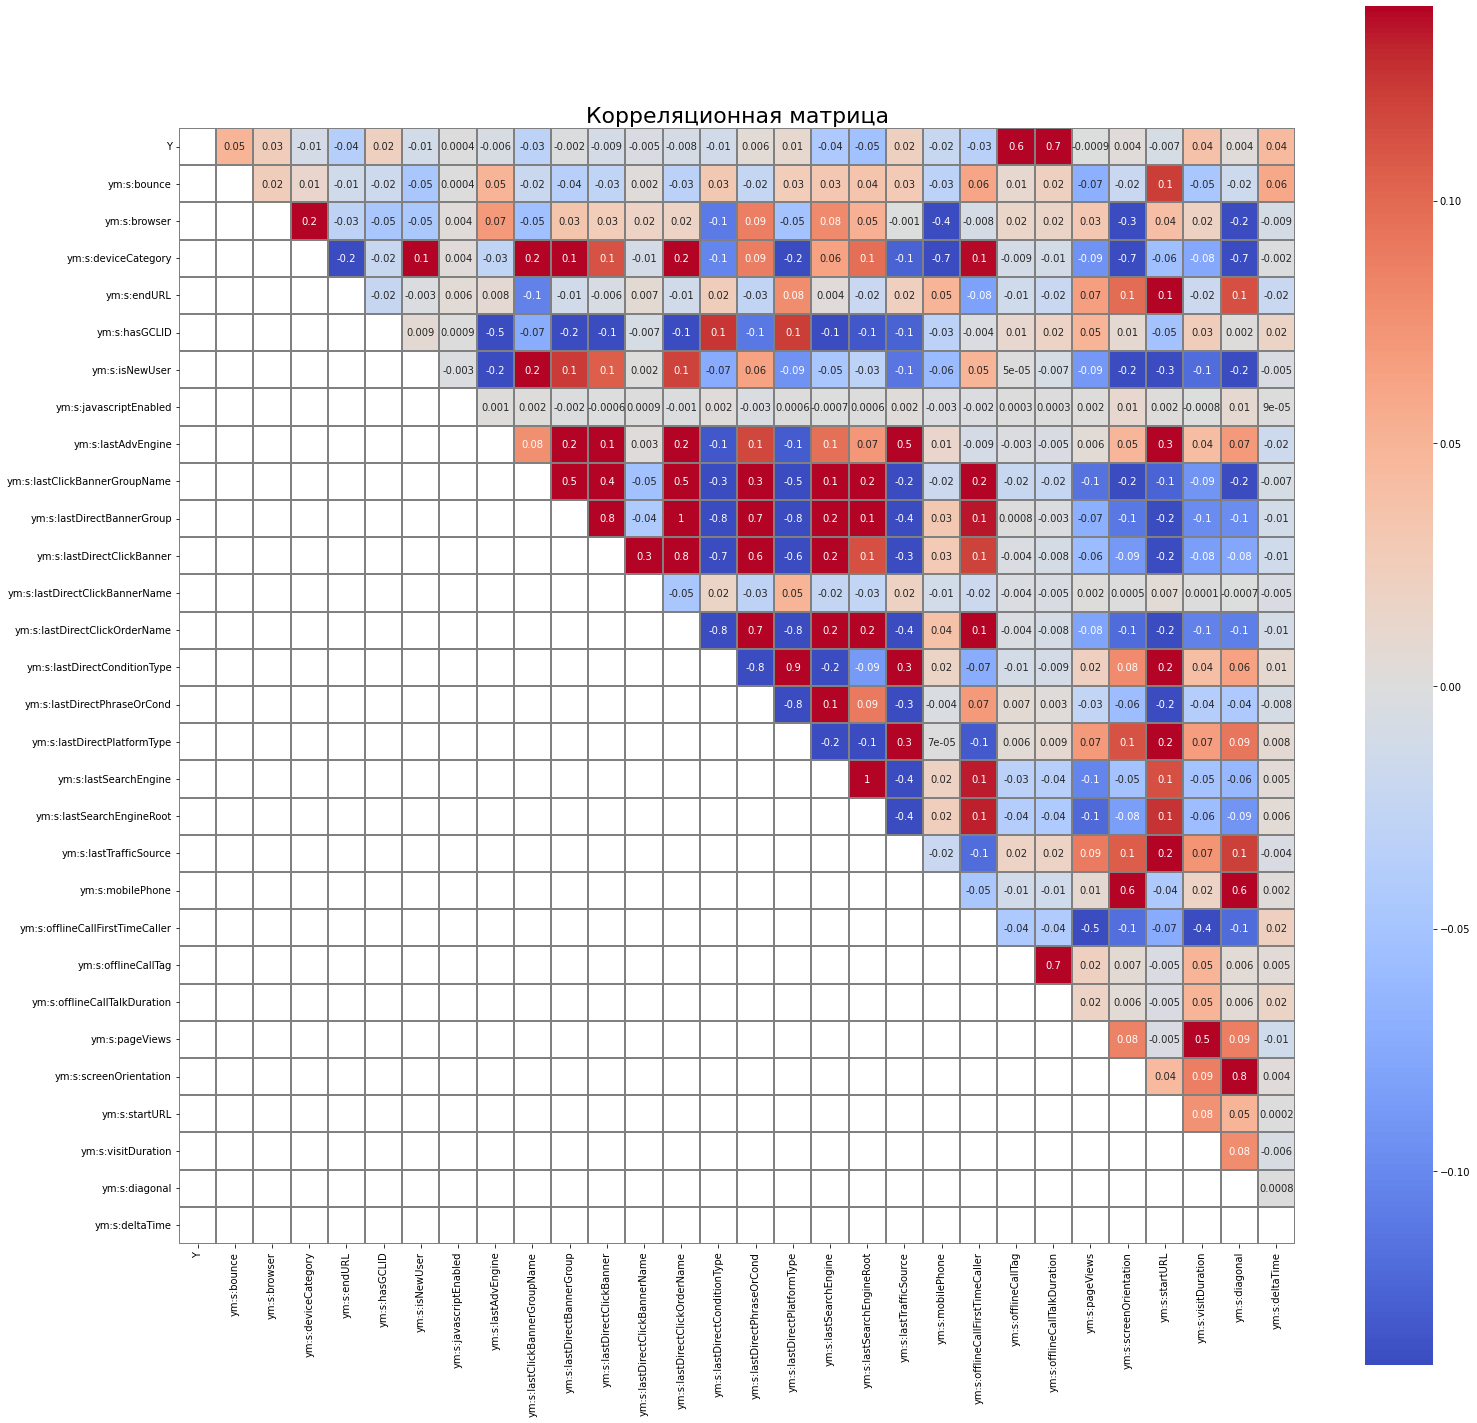

In [157]:
list11best = scale(df11)

(8917, 29) (8917,)
                              Specs        Score
22     ym:s:offlineCallTalkDuration  8049.418684
21              ym:s:offlineCallTag  2706.469751
28                   ym:s:deltaTime    50.967680
17        ym:s:lastSearchEngineRoot    40.715878
16            ym:s:lastSearchEngine    32.701220
3                       ym:s:endURL    26.130270
19                 ym:s:mobilePhone    20.717821
20  ym:s:offlineCallFirstTimeCaller    20.616981
0                       ym:s:bounce    11.290957
10       ym:s:lastDirectClickBanner     6.514971
27                    ym:s:diagonal     5.586831
26               ym:s:visitDuration     4.848548
2               ym:s:deviceCategory     4.099371
18           ym:s:lastTrafficSource     3.893547
1                      ym:s:browser     3.678778
11   ym:s:lastDirectClickBannerName     3.382692
24           ym:s:screenOrientation     3.357141




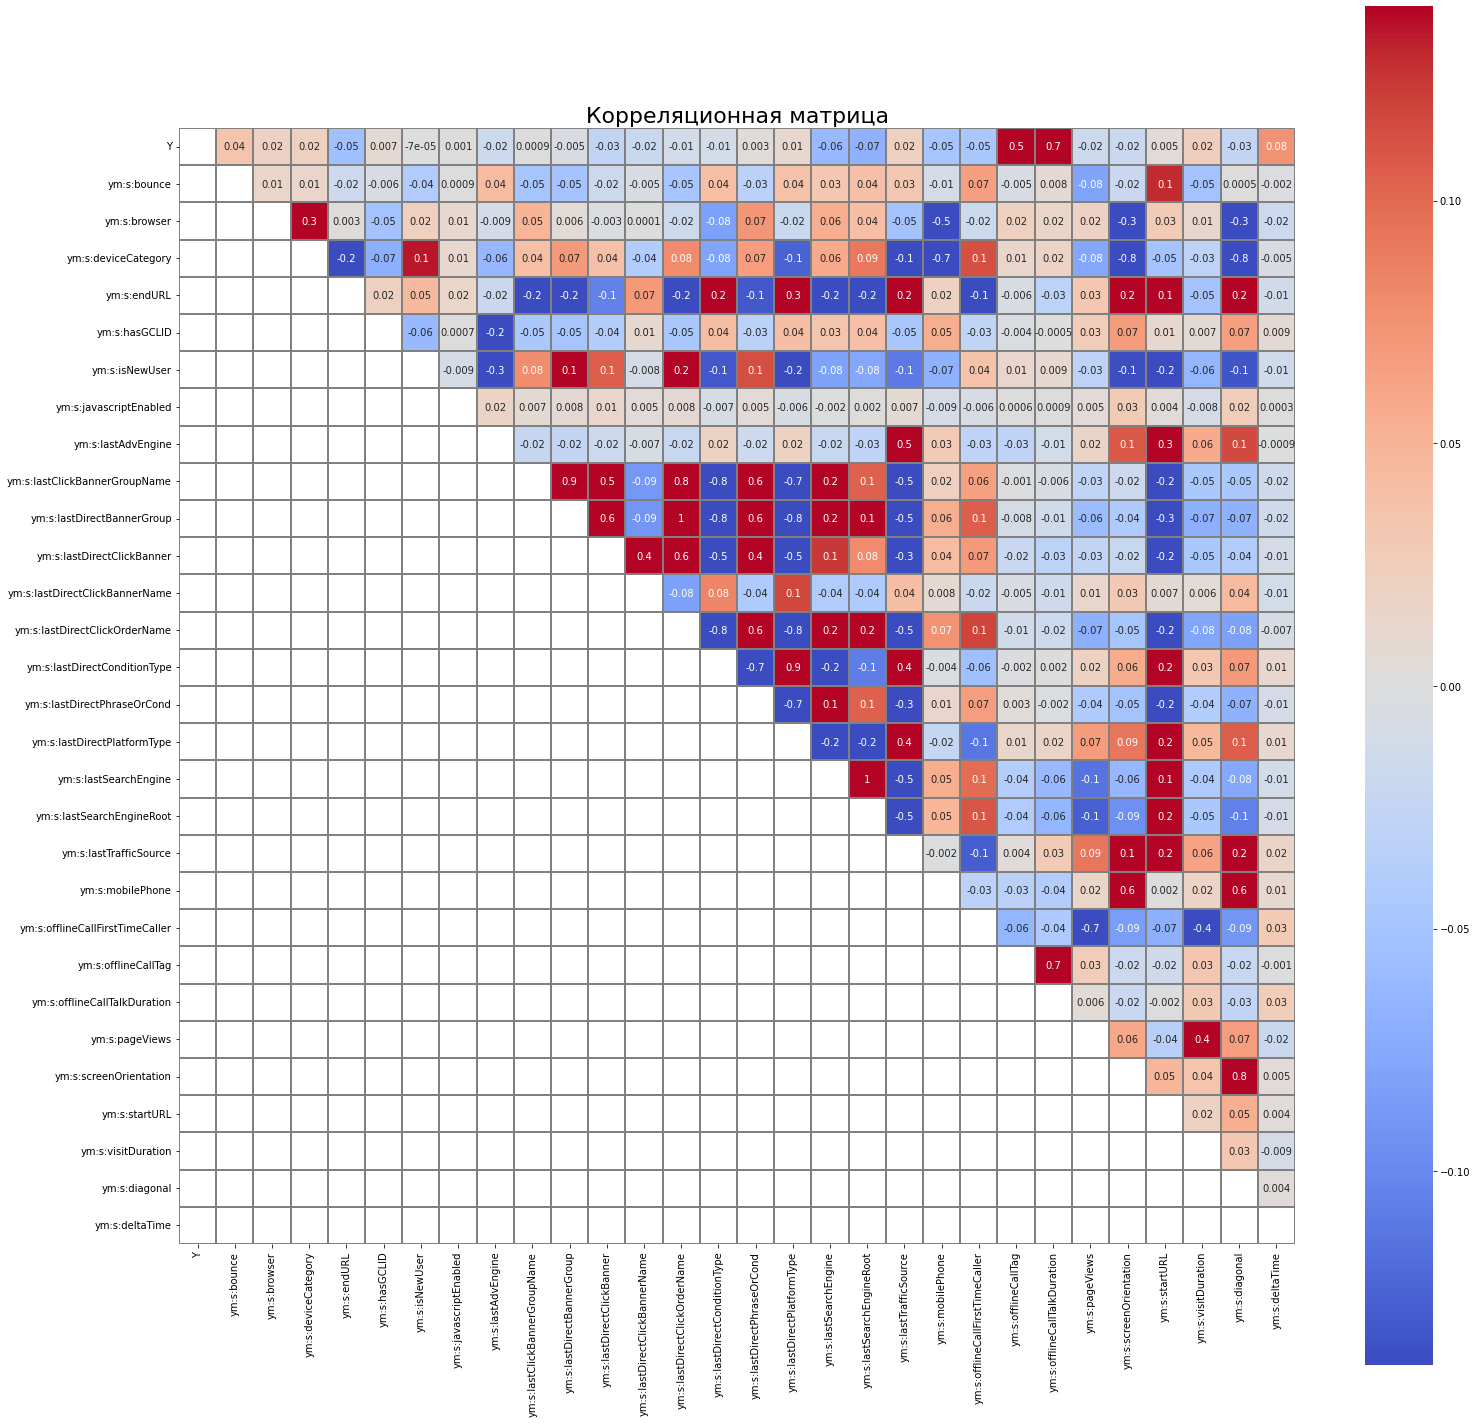

In [159]:
list12best = scale(df12)

(392424, 22) (392424,)
                              Specs         Score
14              ym:s:offlineCallTag  2.018864e+06
15     ym:s:offlineCallTalkDuration  2.140084e+05
19               ym:s:visitDuration  1.731009e+03
13  ym:s:offlineCallFirstTimeCaller  1.558949e+03
21                   ym:s:deltaTime  1.277286e+03
16                   ym:s:pageViews  4.387640e+02
12           ym:s:lastTrafficSource  2.707730e+02
8        ym:s:lastDirectClickBanner  2.468946e+02
7        ym:s:lastDirectBannerGroup  2.443790e+02
10    ym:s:lastDirectClickOrderName  2.044727e+02
20                    ym:s:diagonal  1.872077e+02
17           ym:s:screenOrientation  1.666808e+02
1               ym:s:deviceCategory  1.490345e+02
4                    ym:s:isNewUser  1.321352e+02
6                ym:s:lastAdvEngine  5.868933e+01
18                    ym:s:startURL  5.007078e+01
2                       ym:s:endURL  4.053623e+01




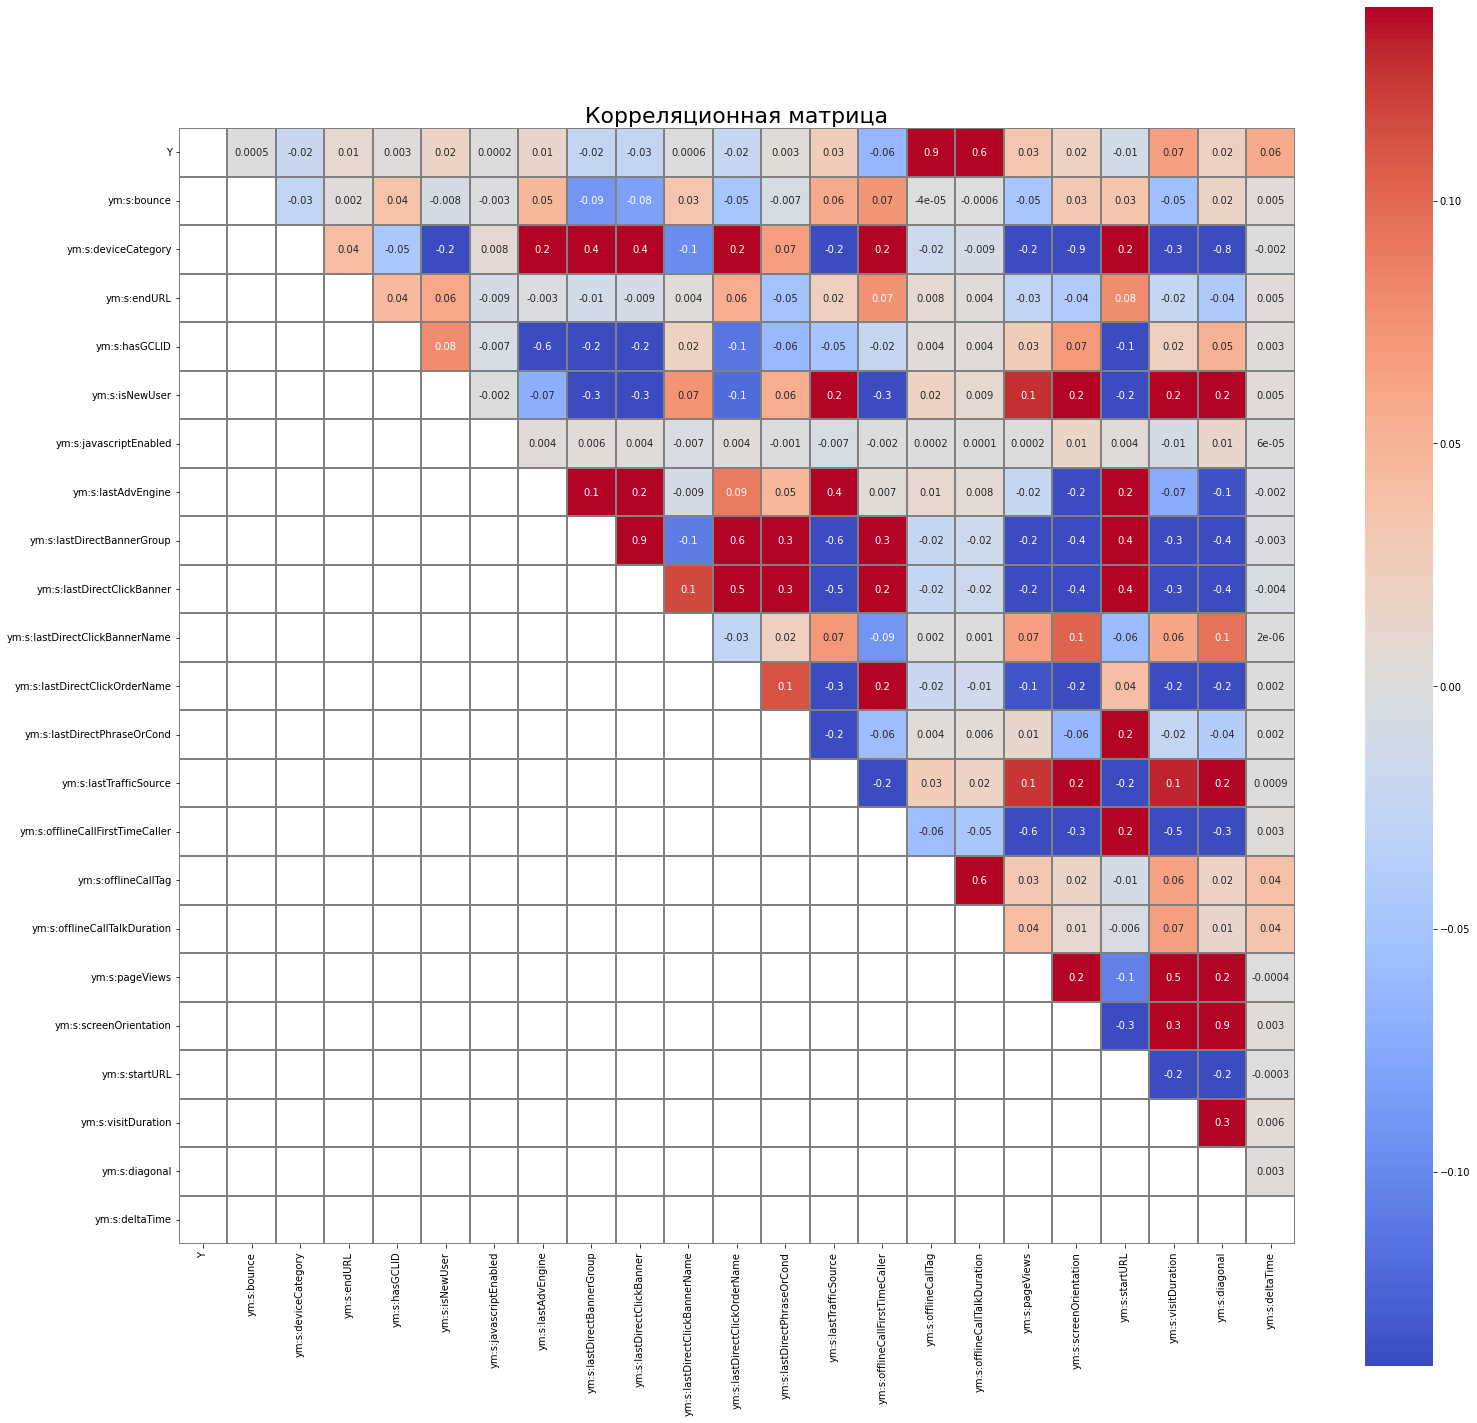

In [160]:
list3best = scale(df3)

(302157, 29) (302157,)
                              Specs          Score
22     ym:s:offlineCallTalkDuration  285419.624090
21              ym:s:offlineCallTag   69676.384958
13     ym:s:lastDirectConditionType    1136.409610
9        ym:s:lastDirectBannerGroup     853.446733
10       ym:s:lastDirectClickBanner     413.601386
15      ym:s:lastDirectPlatformType     344.418650
26               ym:s:visitDuration     250.333805
8     ym:s:lastClickBannerGroupName     228.192872
20  ym:s:offlineCallFirstTimeCaller     196.870334
4                     ym:s:hasGCLID     151.032026
18           ym:s:lastTrafficSource     127.468290
12    ym:s:lastDirectClickOrderName     106.070441
23                   ym:s:pageViews      99.715366
5                    ym:s:isNewUser      76.334856
3                       ym:s:endURL      73.447530
17        ym:s:lastSearchEngineRoot      69.379864
7                ym:s:lastAdvEngine      64.528936




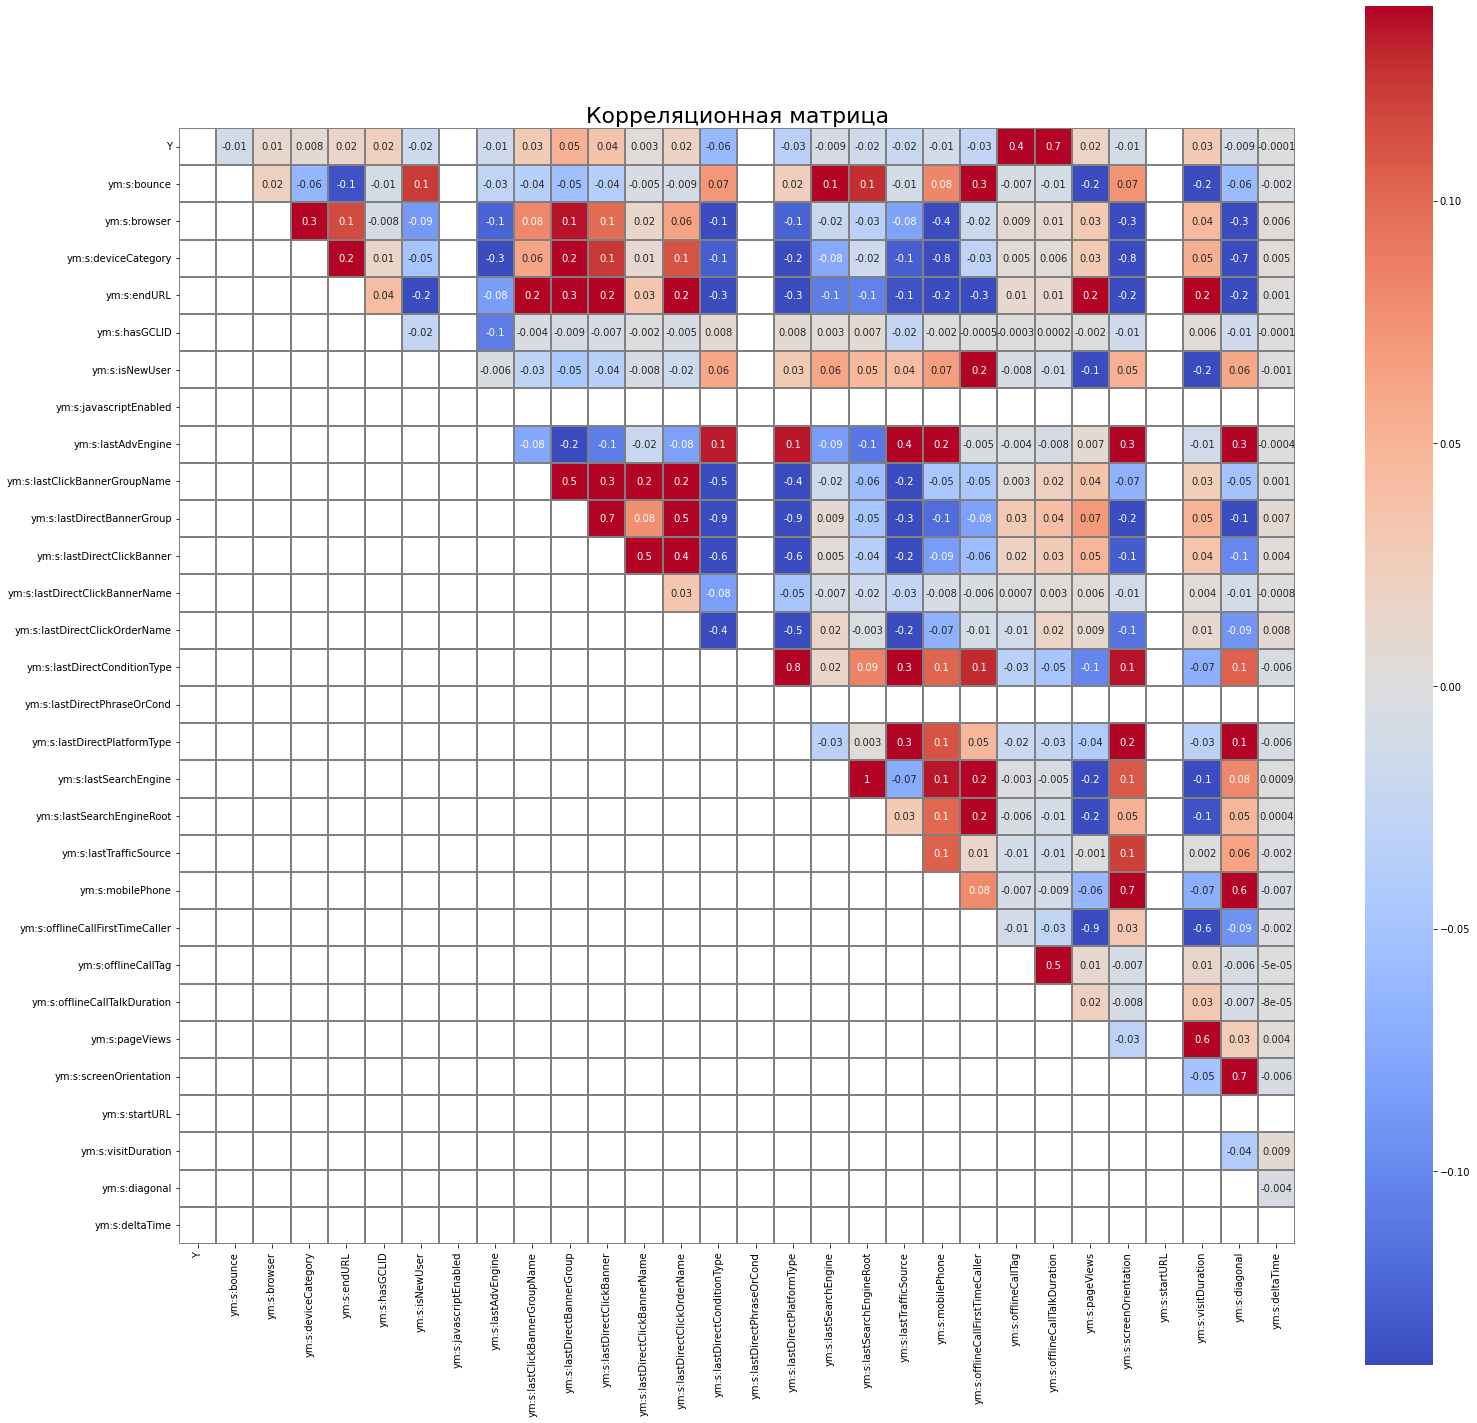

In [161]:
list4best = scale(df4)

## Model LogReg

(122948, 8) (122948,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12181
           1       0.98      0.99      0.99       114

    accuracy                           1.00     12295
   macro avg       0.99      1.00      0.99     12295
weighted avg       1.00      1.00      1.00     12295

precision score:  0.9826086956521739
recall score:  0.9912280701754386


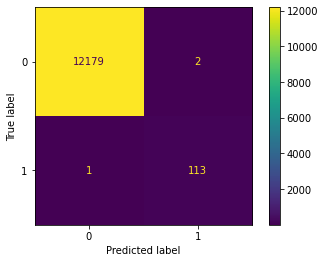

Confusion Matrix:
-----------------
True Negatives: 12179
False Positives: 2
False Negatives: 1
True Positives: 113
-----------------
(8917, 8) (8917,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       879
           1       1.00      0.92      0.96        13

    accuracy                           1.00       892
   macro avg       1.00      0.96      0.98       892
weighted avg       1.00      1.00      1.00       892

precision score:  1.0
recall score:  0.9230769230769231


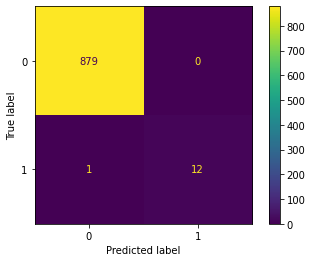

Confusion Matrix:
-----------------
True Negatives: 879
False Positives: 0
False Negatives: 1
True Positives: 12
-----------------
(392424, 8) (392424,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39157
           1       1.00      0.95      0.98        86

    accuracy                           1.00     39243
   macro avg       1.00      0.98      0.99     39243
weighted avg       1.00      1.00      1.00     39243

precision score:  1.0
recall score:  0.9534883720930233


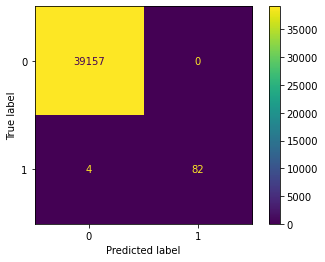

Confusion Matrix:
-----------------
True Negatives: 39157
False Positives: 0
False Negatives: 4
True Positives: 82
-----------------
(302157, 8) (302157,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30187
           1       1.00      0.86      0.93        29

    accuracy                           1.00     30216
   macro avg       1.00      0.93      0.96     30216
weighted avg       1.00      1.00      1.00     30216

precision score:  1.0
recall score:  0.8620689655172413


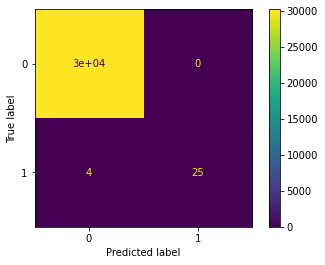

Confusion Matrix:
-----------------
True Negatives: 30187
False Positives: 0
False Negatives: 4
True Positives: 25
-----------------


In [165]:
best_features = [list11best,list12best,list3best,list4best]
dfs = [df11, df12, df3, df4]
for cols, df1 in zip(best_features, dfs): 

  # берем лучшие колонки, у которых выявлена корреляция и строим регрессионную модель
  X = df1[cols]
  y = df1['Y']
  print(X.shape,y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  from sklearn.linear_model import LogisticRegression
  model = LogisticRegression()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  accuracy_score(y_test,y_pred)
  # plot_confusion_matrix(model,X_test,y_test)#, normalize='all')
  print(classification_report(y_test,y_pred))
  print('precision score: ', precision_score(y_test,y_pred))
  print('recall score: ', recall_score(y_test,y_pred))  

  cm = confusion_matrix(y_test,y_pred)
  disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
  disp.plot()
  plt.show()

  # https://www.learndatasci.com/glossary/binary-classification/
  # Create a confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  # Print the confusion matrix
  print('Confusion Matrix:')
  print('-----------------')
  print(f'True Negatives: {tn}')
  print(f'False Positives: {fp}')
  print(f'False Negatives: {fn}')
  print(f'True Positives: {tp}')
  print('-----------------')
  cm = confusion_matrix(y_test, y_pred)
